### Посмотрим на данные

In [14]:
from PIL import Image

In [ ]:
orig_img = Image.open("./dataset_sample/original_images/000.jpg")
orig_img

In [ ]:
mask_img = Image.open("./dataset_sample/label_images_rgb/000.png")
mask_img

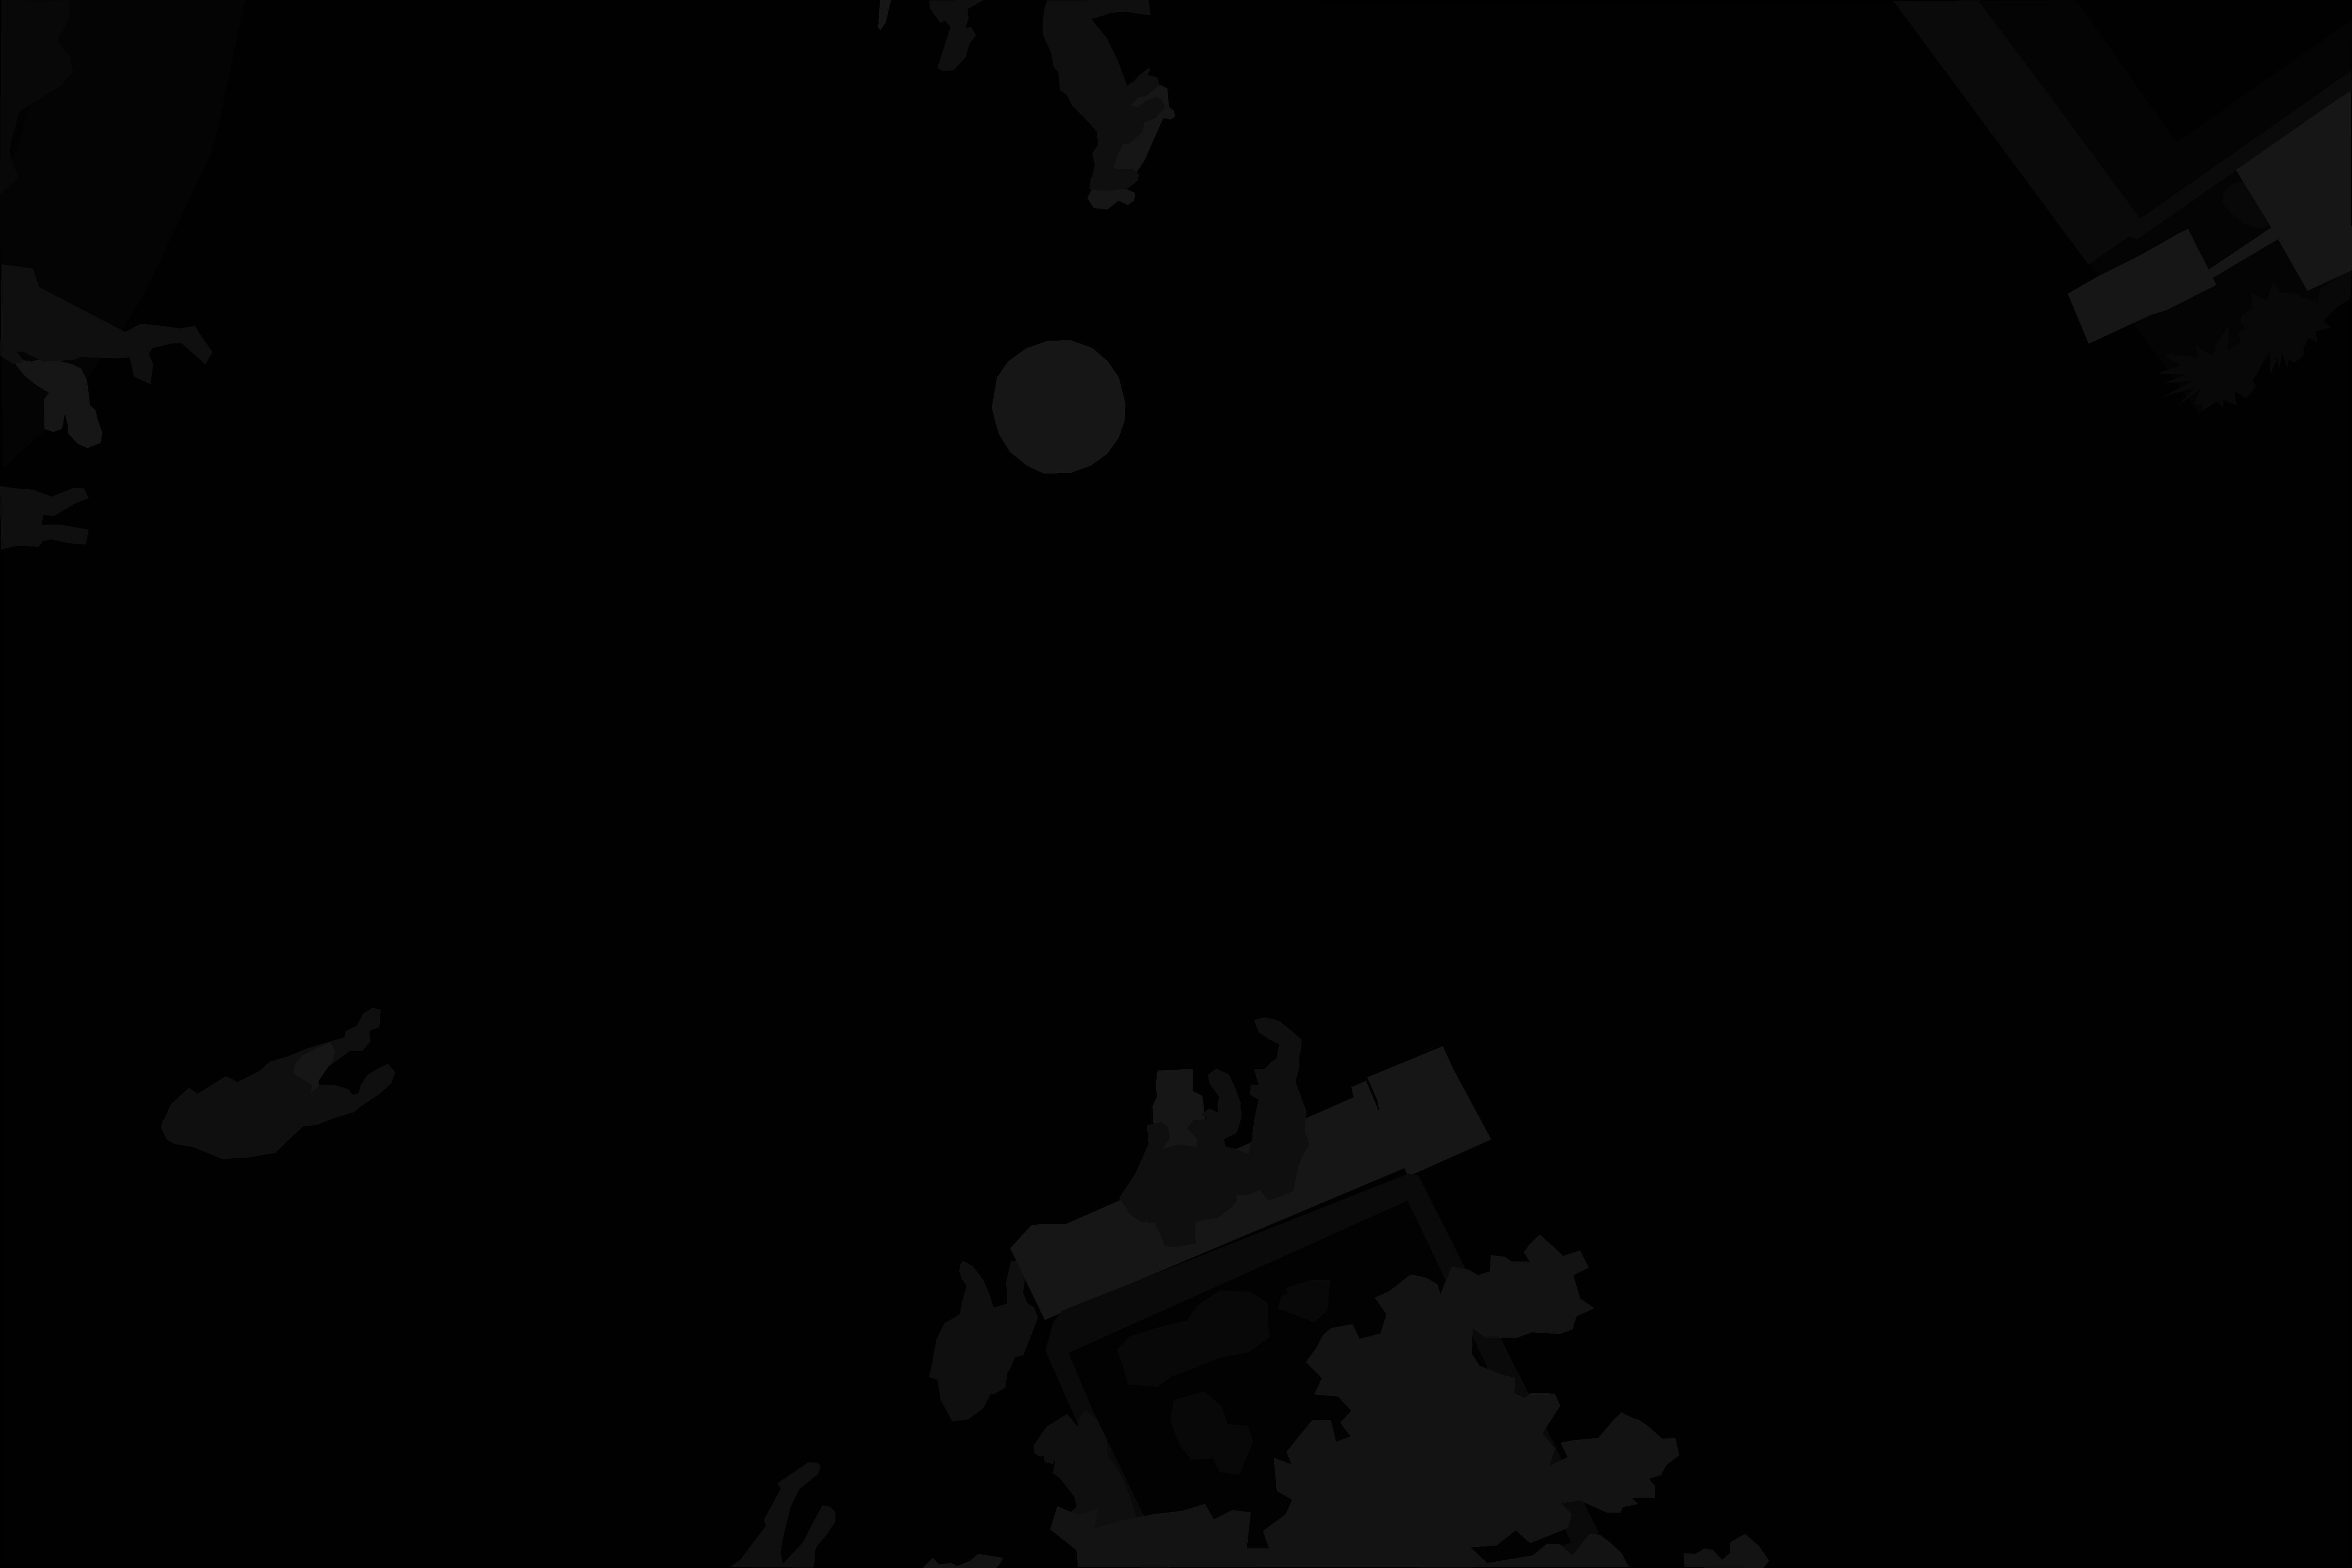

In [17]:
mask_img = Image.open("./dataset_sample/label_images_semantic/000.png")
mask_img

In [18]:
import numpy as np
mask_img_arr = np.array(mask_img)
mask_img_arr.shape

(4000, 6000)

In [19]:
np.unique(mask_img_arr)

array([ 0,  1,  2,  4,  8, 10, 15, 19, 22], dtype=uint8)

### Создадим датасет

In [72]:
from torch.utils.data import Dataset, DataLoader
import os

class SegmentationDataset(Dataset):
    
    def __init__(self, imgs_dir, masks_dir):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        
        self.imgs_paths = os.listdir(self.imgs_dir)
        self.imgs_paths.sort()
        
        self.masks_paths = os.listdir(self.masks_dir)
        self.masks_paths.sort()
        
    def __len__(self):
        return len(self.imgs_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.imgs_dir, self.imgs_paths[idx]))
        # TODO: Изменить размер изображения, используя Pytorch Transformations, вынести размер изображения как параметр
        img = cv2.resize(img, (512, 512))
        # TODO: Перевести в тензор, используя Pytorch Transformations
        img = torch.from_numpy(img).float()
        # TODO: Добавить нормировку изображения, используя Pytorch Transformations
        # TODO: Добавить аугментацию
        
        # Меняем размерность с (ширина x высота x количество каналов) на (количество каналов х ширина х высота)
        img = img.permute(2, 0, 1)
        
        mask = cv2.imread(os.path.join(self.masks_dir, self.masks_paths[idx]), cv2.IMREAD_GRAYSCALE)
        # TODO: Аналогично совершить эти преобразования, используя Pytorch Transformations
        mask = cv2.resize(mask, (512, 512))
        mask = torch.from_numpy(mask).long()
        
        return img, mask

In [102]:
train_dataset = SegmentationDataset("./dataset_sample/original_images/", "./dataset_sample/label_images_semantic/")

In [ ]:
# TODO: Отдельный датасет на validation set

In [74]:
len(train_dataset)

8

In [75]:
img, mask = next(iter(train_dataset))

In [76]:
img.shape, img.dtype

(torch.Size([3, 512, 512]), torch.float32)

In [77]:
mask.shape, mask.dtype

(torch.Size([512, 512]), torch.int64)

In [103]:
# TODO: Поиграться с размером батча
batch_size= 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# TODO: Отдельный loader на validation set

### Создадим модель

In [82]:
import segmentation_models_pytorch as smp

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23)

In [86]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride

In [100]:
# TODO: Заменить голову на свою
# model.segmentation_head = ....
model.segmentation_head

SegmentationHead(
  (0): Conv2d(16, 23, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Identity()
  (2): Activation(
    (activation): Identity()
  )
)

In [ ]:
# TODO: Поиграться с заморозкой весов
for param in model.encoder.parameters():
    param.requires_grad = False

In [104]:
img_batch, mask_batch = next(iter(train_loader))

In [105]:
img_batch.shape

torch.Size([3, 3, 512, 512])

In [106]:
mask_batch.shape

torch.Size([3, 512, 512])

In [107]:
output_batch = model(img_batch)

In [108]:
output_batch.shape

torch.Size([3, 23, 512, 512])

In [109]:
from torch.nn import CrossEntropyLoss

CrossEntropyLoss()(output_batch, mask_batch) 

tensor(3.5048, grad_fn=<NllLoss2DBackward>)

### Обучение

In [112]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cpu


In [113]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride

In [121]:
epoch_count = 10

loss = CrossEntropyLoss()

In [122]:
# TODO: поиграться с learning rate
learning_rate = 0.01

# TODO поиграться с выбором алгоритма в целом
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [123]:
from tqdm import tqdm

for epoch_num in range(epoch_count):
    for batch_num, (img_batch, mask_batch) in enumerate(tqdm(train_loader)):

        img_batch = img_batch.to(device) 
        mask_batch = mask_batch.to(device)
    
        optimizer.zero_grad()
        output_batch = model(img_batch)
        loss_value = loss(output_batch, mask_batch)

        loss_value.backward()
        optimizer.step()           
     
        # TODO: Добавить вычисление метрики, исходя из значений output_batch и mask_batch
        # Варианта метрик: IoU, попиксельная Accuracy
    print(f"Epoch {epoch_num} / {epoch_count} | train loss = {loss_value}")    
        
    # TODO: Добавить расчет метрик и лосса на валидации и их логирование
    # print(f"Epoch {epoch_num} / {epoch_count} | val Loss = {val_loss} | val accuracy = {val_accuracy}")

    # TODO: Сохранять лучшую модель по метрикам на валидации
    
    # TODO: Добавить early stopping: если модель на валидации не улучшается некоторое 
    # количество эпох, то прекратить обучение

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.66s/it]


Epoch 0 / 10 | train loss = 2.044912338256836


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:31<00:00, 10.49s/it]


Epoch 1 / 10 | train loss = 1.8907577991485596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:34<00:00, 11.40s/it]


Epoch 2 / 10 | train loss = 2.0336196422576904


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.82s/it]


Epoch 3 / 10 | train loss = 2.1625030040740967


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.23s/it]


Epoch 4 / 10 | train loss = 1.8389796018600464


 33%|███████████████████████████████████████████████████▋                                                                                                       | 1/3 [00:21<00:43, 21.58s/it]


KeyboardInterrupt: 

In [ ]:
# TODO: Нарисовать графики изменения лосса на трейне/валидации в зависимсоти от эпох и аналогичный график по метрикам